## scRNA-seq multi sample integration analysis

### 表达矩阵读入

In [ ]:
library(Seurat)
library(harmony)
library(dplyr)
library(ggplot2)
library(data.table)

In [ ]:
##读取表达矩阵
count=fread( 'GSE149614_HCC.scRNAseq.S71915.count.txt.gz',data.table = F)
count[1:4,1:4]

In [6]:
##将第一列设为 rownames，并删除
rownames(count)=count[,1]  
count=count[,-1]
count[1:4,1:4]

,HCC01T_AAACCTGAGGGCATGT,HCC01T_AAACCTGAGTCGCCGT,HCC01T_AAACCTGCATTACCTT,HCC01T_AAACCTGGTCACACGC
,<int>,<int>,<int>,<int>
RP11-34P13.7,0,0,0,0
FO538757.2,0,0,0,0
AP006222.2,1,1,0,0
RP4-669L17.10,0,0,0,0


### 创建Seurat对象

In [ ]:
#创建Seurat对象，并初步过滤
scRNA=CreateSeuratObject(counts = count , min.cells = 3, min.features = 200)

In [20]:
table(scRNA@meta.data$orig.ident) 


HCC01T HCC02T HCC03N HCC03T HCC04N HCC04T HCC05N HCC05T HCC06N HCC06T HCC07N 
  2815   4026   1768   4266   3146   3045   4531   2615   4238   4127   3642 
HCC07P HCC07T HCC08N HCC08P HCC08T HCC09N HCC09T HCC10L HCC10N HCC10T 
     0    457   4729      0   4415   1807   2661      0   3001   2693 

In [12]:
#提取orig.ident第6个字符作为分组信息
scRNA@meta.data$Group = substring(scRNA@meta.data$orig.ident ,6)
table(scRNA@meta.data$Group)


    L     N     P     T 
 2843 28687  5971 34414 

In [13]:
#剔除L(转移性淋巴结),P(静脉肿瘤血栓)样本
scRNA<-subset(scRNA,Group %in% c('N','T'))

### QC质控

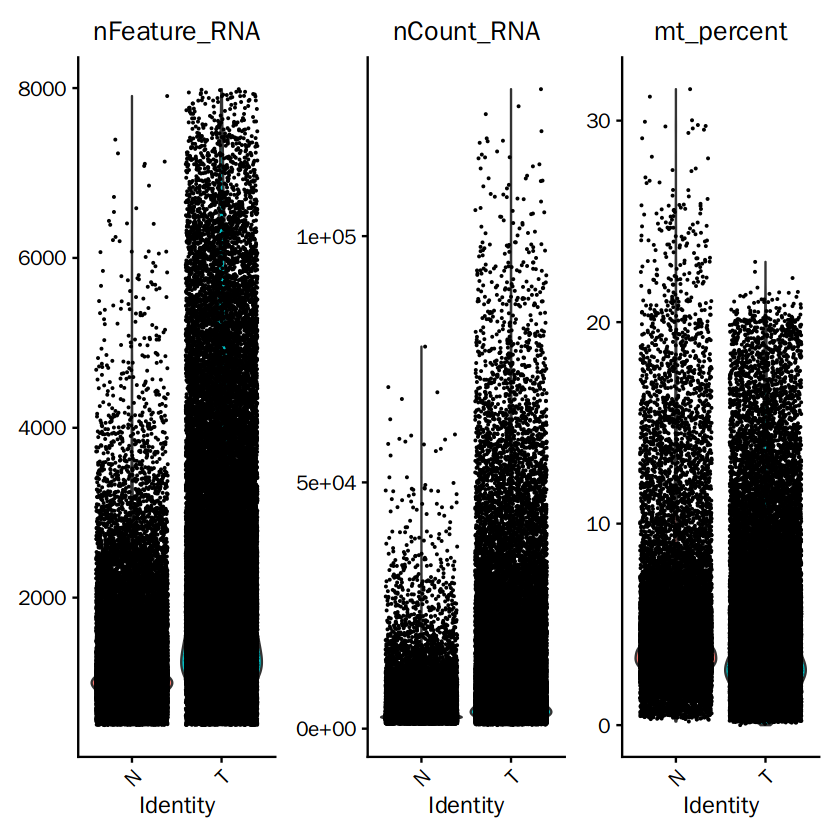

In [17]:
#QC质控
scRNA[["mt_percent"]] <- PercentageFeatureSet(scRNA, pattern = "^MT-")
Vln<-VlnPlot(scRNA, features = c("nFeature_RNA", "nCount_RNA", "mt_percent"), ncol = 3, group.by = "Group",raster=FALSE)
Vln
#ggsave("QC/QC-before.pdf", plot = Vln, width = 8, height = 7)

In [18]:
##对数据进行质控，设置质控标准，此处根据数据原文
minGene=200
maxGene=8000
mt=10

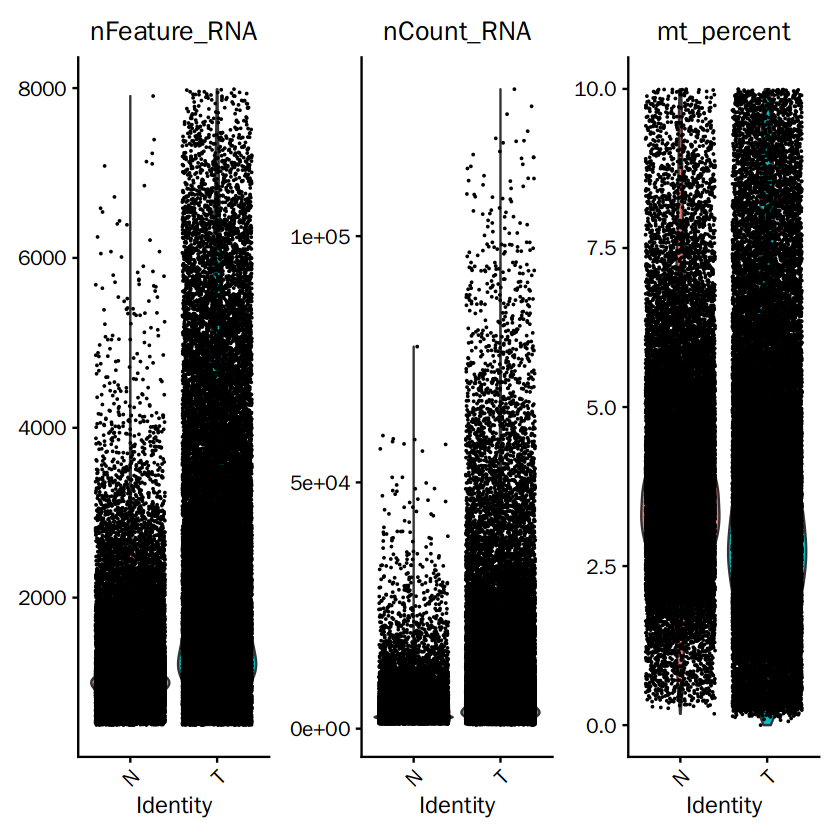

In [19]:
scRNA <- subset(scRNA, subset = nFeature_RNA > minGene &nFeature_RNA < maxGene  & mt_percent < mt)

Vln2 <-VlnPlot(scRNA, group.by = "Group",
                 features = c("nFeature_RNA", "nCount_RNA", "mt_percent"), 
                 pt.size = 0.01) 
Vln2
#ggsave("QC/QC-after.pdf", plot = Vln2, width = 8, height = 7)

In [49]:
##查看质控后各样本细胞数量
table(scRNA@meta.data$orig.ident)


HCC01T HCC02T HCC03N HCC03T HCC04N HCC04T HCC05N HCC05T HCC06N HCC06T HCC07N 
  2815   4026   1768   4266   3146   3045   4531   2615   4238   4127   3642 
HCC07P HCC07T HCC08N HCC08P HCC08T HCC09N HCC09T HCC10L HCC10N HCC10T 
     0    457   4729      0   4415   1807   2661      0   3001   2693 

### 多样本整合去批次

In [ ]:
##筛选高可变基因，并进行数据降维
scRNA <- NormalizeData(scRNA) %>% 
  FindVariableFeatures(selection.method = "vst",nfeatures = 2000) %>% 
  ScaleData() %>% 
  RunPCA(npcs = 30, verbose = T)

In [ ]:
library(harmony)
##使用harmony进行多样本整合&批次矫正 
scRNA <- RunHarmony(scRNA,reduction = "pca",group.by.vars = "orig.ident",reduction.save = "harmony")

In [ ]:
#非线性降维，UMAP和tSNE 是Seurat进行非线性降维的方法，首选 UMAP
scRNA <- RunUMAP(scRNA, reduction = "harmony", dims = 1:30,reduction.name = "umap")

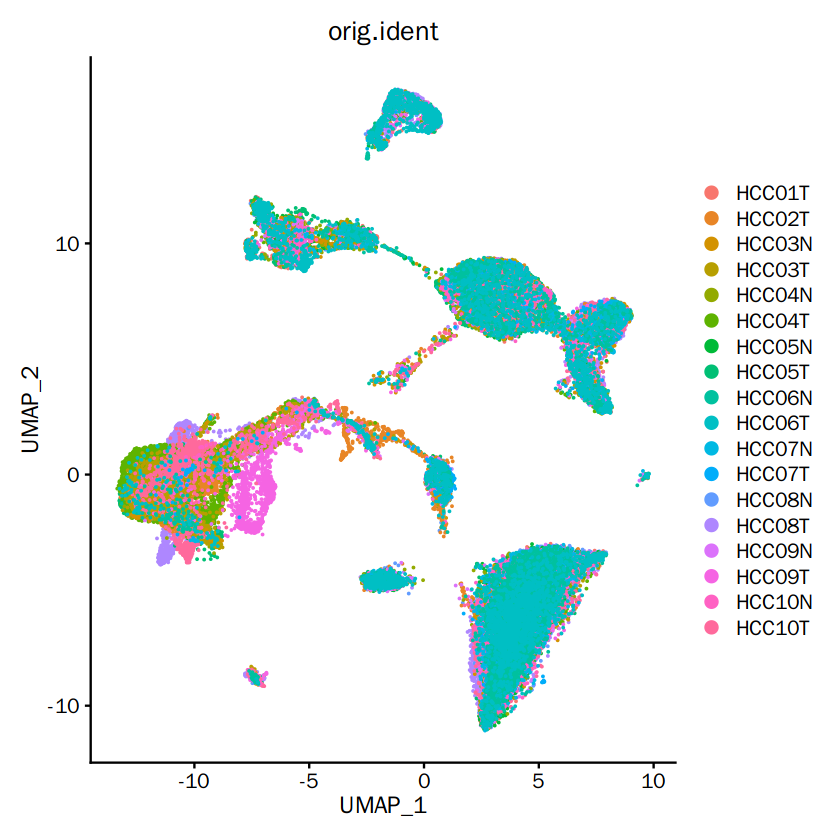

In [27]:
#查看去批次效果
DimPlot(scRNA, reduction = "umap",group.by = "orig.ident")

In [ ]:
##基于共享近邻（SNN）法识别细胞簇(cluster)
scRNA <- FindNeighbors(scRNA, reduction = "harmony", dims = 1:30) %>% 
  FindClusters(resolution = 0.5)  

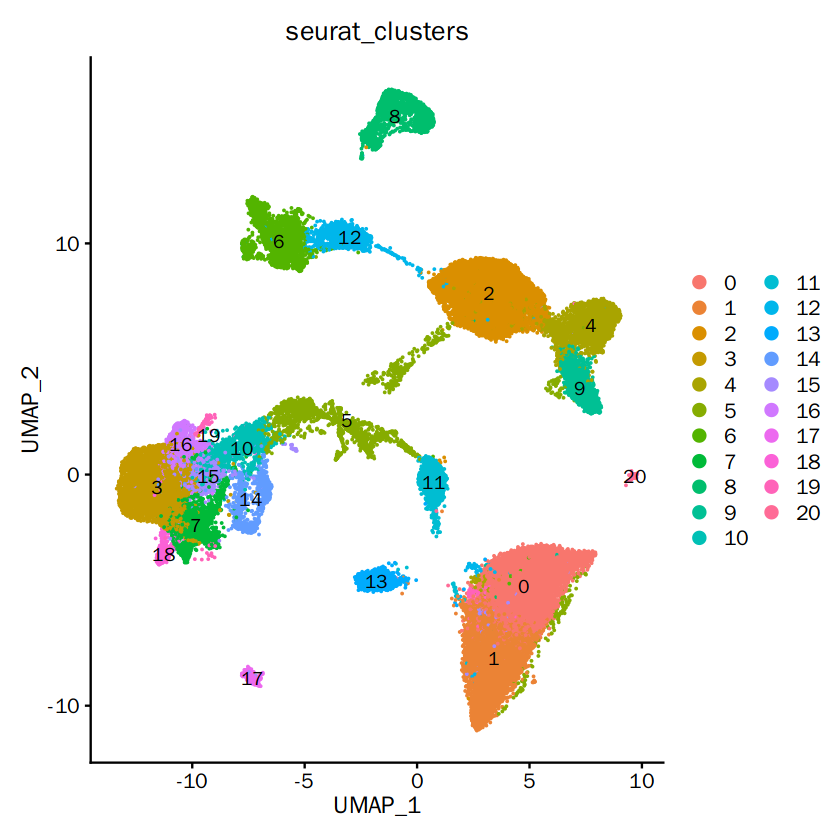

In [29]:
#UMAP可视化细胞分群结果
DimPlot(scRNA, reduction = "umap",group.by = "seurat_clusters",label = T)

In [31]:
##读取数据集提供的细胞注释信息
meta<-read.table('/home/zhaojingwei/DATA/luo/tongji/HCC2/scRNA/GSE149614_HCC.metadata.updated.txt',header = T,row.names = 1)
head(meta)

,sample,res.3,site,patient,stage,virus,celltype
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
HCC01T_AAACCTGAGGGCATGT,HCC01T,13,Tumor,HCC01,I,HBV,T/NK
HCC01T_AAACCTGAGTCGCCGT,HCC01T,16,Tumor,HCC01,I,HBV,Myeloid
HCC01T_AAACCTGCATTACCTT,HCC01T,25,Tumor,HCC01,I,HBV,T/NK
HCC01T_AAACCTGGTCACACGC,HCC01T,2,Tumor,HCC01,I,HBV,T/NK
HCC01T_AAACCTGTCCAGTATG,HCC01T,2,Tumor,HCC01,I,HBV,T/NK
HCC01T_AAACGGGTCGAGCCCA,HCC01T,38,Tumor,HCC01,I,HBV,Myeloid


In [32]:
#Addmetdata
scRNA <- AddMetaData(object = scRNA,
                     metadata = meta) 

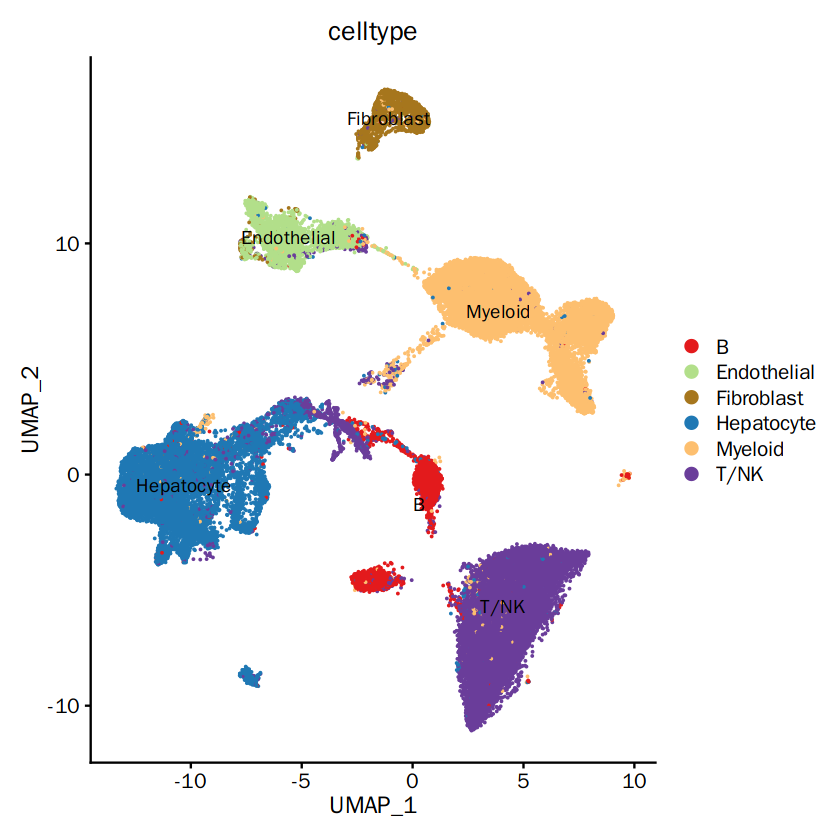

In [37]:
col<-c('Hepatocyte'="#1F78B4",'Endothelial'="#B2DF8A",'B'="#E31A1C",
       'Myeloid'="#FDBF6F",'T/NK'="#6A3D9A",'Fibroblast'="#A6761D")
celltype<-DimPlot(scRNA, reduction = "umap",group.by = "celltype",label = T,cols = col)
celltype
#ggsave("Celltype/celltype_umap.pdf", plot = celltype, width = 8, height = 7)

In [ ]:
##DotPlot marker基因

In [40]:
Marker = list('B' =c('CD79A','MZB1','IGHG1','JCHAIN'),
              'EC'=c('VWF','PECAM1','FCGR2B'),
              'Fib'=c('COL1A1', 'ACTA2','COL1A2'),
              'Hep'=c('ALB','SERPINA1','HNF4A','EPCAM'),
              'Myeloid'=c('CD14','CD68','CD163'),
              'T/NK'=c('CD3D', 'CD3E','NKG7','GNLY'))

In [ ]:
#气泡图展示marker在各cluster表达情况
DotPlot(scRNA,features=Marker,cols = c('#EEE9E9','#5D478B'),group.by='celltype') +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

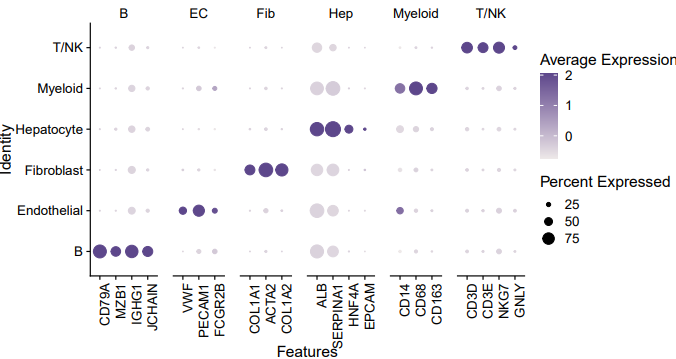

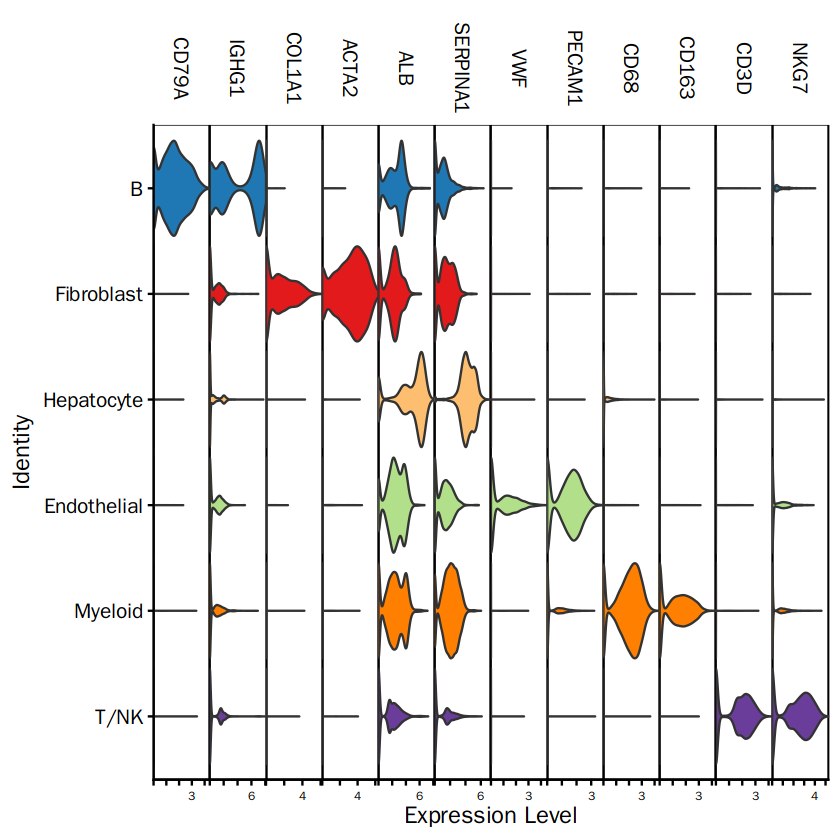

In [45]:
##小提琴展示各Celltype特异性maker
Idents(scRNA)<-scRNA@meta.data$celltype
Markers=c('CD79A','IGHG1','COL1A1','ACTA2','ALB','SERPINA1','VWF','PECAM1','CD68','CD163','CD3D','NKG7')
VlnPlot(scRNA, 
        features = Markers, 
        stack=T,
        pt.size=0,
        split.by = 'celltype',   
        cols=col,
) +
  theme(legend.position = "none")

In [ ]:
##热图均值展示Celltype特异性maker
AverageHeatmap(object = scRNA,
               annoCol = TRUE,
               myanCol=col,
               markerGene = Markers,
               cluster.order = c('B','Fibroblast','Hepatocyte','Endothelial','Myeloid','T/NK'))

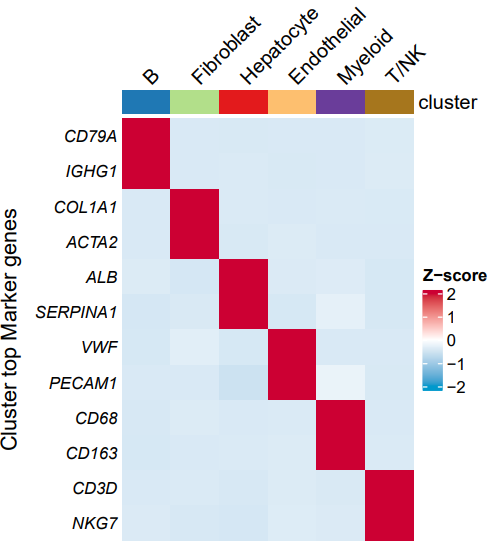

In [ ]:
#可视化样本细胞比例
library(scRNAtoolVis)
cellRatio<-cellRatioPlot(object = scRNA,
                         sample.name = "Group",
                         celltype.name = "celltype",
                         flow.curve = 0.5,fill.col = col)+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))
cellRatio

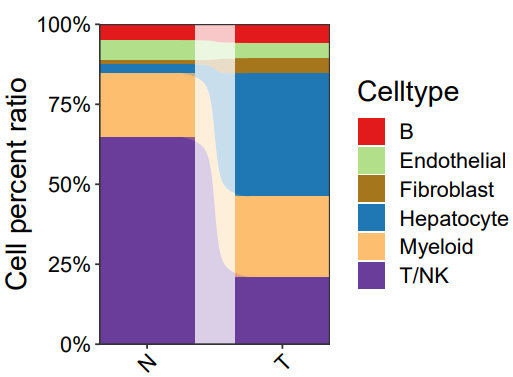

## 细胞组间差异分析

In [50]:
#新增Label列，以区分不同分组间的细胞来源
scRNA@meta.data$Label<-paste(scRNA@meta.data$celltype,scRNA@meta.data$Group,sep = '_')
#查看Label分组情况
table(scRNA@meta.data$Label)


          B_N           B_T Endothelial_N Endothelial_T  Fibroblast_N 
         1337          1795          1675          1556           335 
 Fibroblast_T  Hepatocyte_N  Hepatocyte_T     Myeloid_N     Myeloid_T 
         1470           751         11968          5363          7785 
       T/NK_N        T/NK_T 
        17401          6546 

In [51]:
#将scRNA对象的Idents切换至 Label
Idents(scRNA)<-scRNA@meta.data$Label  

In [52]:
#以Fibroblast细胞为例，探究Tumor组 与 Normal组之间 Fibroblast的差异基因
Fib_DEG<-FindMarkers(scRNA,ident.1 = 'Fibroblast_T',ident.2 = 'Fibroblast_N',only.pos = F, min.pct = 0.25, logfc.threshold = 0.25)

In [54]:
#导入火山图脚本
source('/home/zhaojw/DATA/code/VolcanoPlot.R')
#构建中间数据
dif=data.frame(
  symbol=rownames(Fib_DEG),
  log2FoldChange=Fib_DEG$avg_log2FC,
  padj=Fib_DEG$p_val_adj)
head(dif, n=3)

,symbol,log2FoldChange,padj
,<chr>,<dbl>,<dbl>
1,FN1,1.980828,5.297860e-66
2,CXCL14,-3.064529,8.176852e-62
3,APOA2,1.517979,7.723888e-55


In [ ]:
#可以指定要标记的差异基因数量
VolcanoPlot(dif, padj=0.05, title="Fibroblast_Tumor_vs_Normal",label.max = 10)

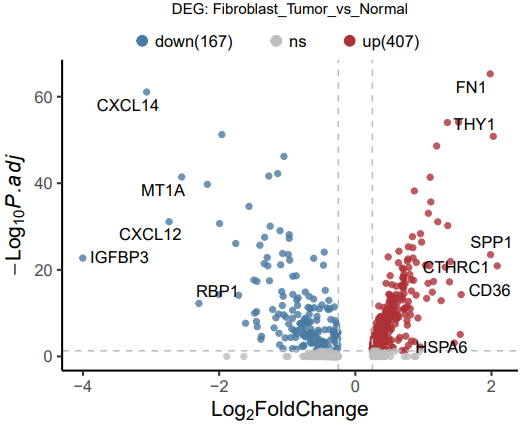

## GO/KEGG富集分析

In [58]:
#对上一步差异分析得到的差异基因进行富集分析
library(clusterProfiler)
#Fib_DEG对象新增基因名列
Fib_DEG$symbol<-rownames(Fib_DEG)

#为Fib_DEG对象新增change列,定义上、下调基因
Fib_DEG$change <- ifelse(Fib_DEG$p_val_adj < 0.05 & 
                                  abs(Fib_DEG$avg_log2FC)>= 0.25,
                                ifelse(Fib_DEG$avg_log2FC > 0.25,'UP','Down'),'Stable')
table(Fib_DEG$change)

#取出上、下调基因
Fib_DEG_sub<-subset(Fib_DEG,change %in% c('UP','Down'))

#将基因SYMBOL转换为ENTREZID
gid <- bitr(unique(Fib_DEG_sub$symbol), 'SYMBOL', 'ENTREZID', OrgDb= 'org.Hs.eg.db')
Fib_DEG_sub <- full_join(Fib_DEG_sub, gid, by=c('symbol' = 'SYMBOL'))


  Down Stable     UP 
   167    230    407 



'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(unique(Fib_DEG_sub$symbol), "SYMBOL", "ENTREZID", OrgDb = "org.Hs.eg.db"):
“5.05% of input gene IDs are fail to map...”


In [59]:
#此处选择富集GO里的BP(生物学过程)通路
GO_BP = compareCluster(ENTREZID ~ change, data = Fib_DEG_sub, fun='enrichGO',ont='BP', OrgDb='org.Hs.eg.db')

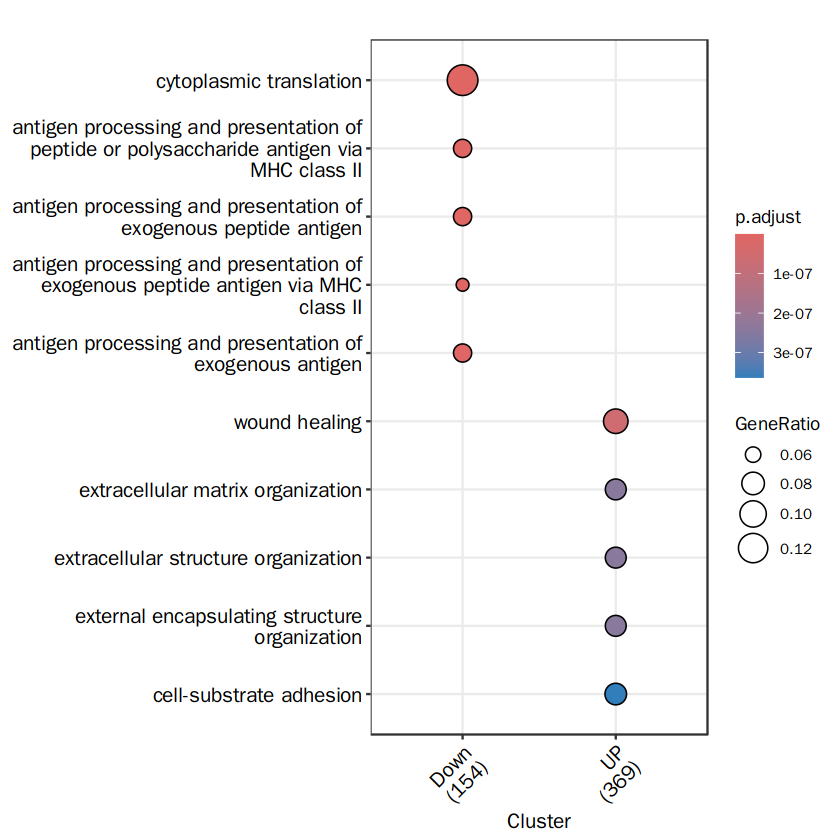

In [60]:
#可视化上、下调基因富集到的各 TOP5 GO BP通路
dotplot(GO_BP, label_format=40,showCategory=5) + theme(axis.text.x = element_text(angle=45, hjust=1)) + scale_color_gradient(high="#4b5cc4",low="#FE8D3C")

In [ ]:
#将EntrezID转换为Symbol
GO_BP = setReadable(GO_BP, #前面分析的结果
                    OrgDb = "org.Hs.eg.db", #人类数据库
                    keyType = "ENTREZID") #要转换的基因类型
#保存GO富集结果
write.csv(GO_BP@compareClusterResult,file = 'Fibroblast_Tumor_vs_Normal_DEG_GO_BP.csv')

In [ ]:
save(scRNA,file='~/DATA/code/myCode/scRNA.rdata')